# Presidential Election 2022

In [1]:
from pynsee import get_geodata, get_geodata_list
import requests
import tempfile
import pandas as pd

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [4]:
# download data from data.gouv.fr
url = 'https://www.data.gouv.fr/fr/datasets/r/1ffb6125-1cea-4a03-80be-520c1c3a5411'

def download_data(url=url):
    
    results = requests.get(url)
    dirpath = tempfile.mkdtemp()
    dwnFile = dirpath + '\\fr_presidential_election_1stround_2022.txt'

    with open(dwnFile, 'wb') as f:
        f.write(results.content)
        f.close()
        
    return dwnFile

dwnFile = download_data()

In [5]:
def make_dataframes(dataFile=dwnFile):
    """
    function to make clean dataframes from data.gouv.fr file
        it returns one dataframe containing data about votes by candidate and commune, 
        and a dataframe containing communes agregated data
    """    
    
    # import data
    data = pd.read_csv(dataFile, dtype='str', sep=';', encoding='latin-1', skiprows=1, header=None)
    colNames = pd.read_csv(dataFile, dtype='str', sep=';', encoding='latin-1', nrows=1, header=None)
    colNamesCommunes = colNames.iloc[0,:18].to_list()
    colNamesBallots = colNames.iloc[0,19:len(colNames.columns)].to_list()
    
    # make dataframe only on communes agregated data
    dfCommunes = data.iloc[:,:18]
    dfCommunes.columns = colNamesCommunes
    
    # make dataframe only with detailed data, candidate by candidate
    icols = [x for x in range(4)] + [x for x in range(19, len(data.columns))]
    dfBallots = data.iloc[:, icols]
    dfBallots.columns = [x for x in range(len(dfBallots.columns))]
    colnamesCandidates = colNamesCommunes[:4] + colNamesBallots
    
    # reshape detailed data
    list_df = []
    for icandidate in range(1, 12):
        icols = [x for x in range(4)] + [x for x in range(7 * (icandidate - 1) + 4, 7 * icandidate + 4)]
        dfBallotsCandidate = dfBallots.iloc[:, icols]
        dfBallotsCandidate.columns = colnamesCandidates
        list_df += [dfBallotsCandidate]

    dfFinal = pd.concat(list_df).reset_index(drop=True)

    dfFinal['Voix'] = pd.to_numeric(dfFinal['Voix'])
        
    dfFinal = dfFinal.rename(columns={"Code du département":"dep", "Code de la commune":"com"})
    dfCommunes = dfCommunes.rename(columns={"Code du département":"dep", "Code de la commune":"com"})
    
    # add clean communes id  
    for r in dfCommunes.index:
        dep = str(dfCommunes.loc[r, "dep"])
        comId = str(dfCommunes.loc[r, "com"])
        if dep.startswith('Z'):        
            dep = '97'
        dfCommunes.loc[r,"insee_com"] = dep + comId
        
    dfFinal = dfFinal.merge(dfCommunes, on = ["dep", "com"], how="left")
    
    return dfFinal, dfCommunes

dfBallots, dfCommunes = make_dataframes()

In [6]:
# select only the candidate who has won the most votes for each commune
colList = dfBallots.columns[:4].to_list() + ["insee_com"]
FirstCandidate = dfBallots.loc[dfBallots.reset_index().groupby(colList)['Voix'].idxmax()].reset_index(drop=True)    

In [7]:
FirstCandidate[:2]

,dep,Libellé du département_x,com,Libellé de la commune_x,N°Panneau,Sexe,Nom,Prénom,Voix,% Voix/Ins,...,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,insee_com
0,01,Ain,001,L'Abergement-Clémenciat,3,M,MACRON,Emmanuel,150,"23,26",...,"83,26",16,"2,48","2,98",1,"0,16","0,19",520,"80,62",01001
1,01,Ain,002,L'Abergement-de-Varey,3,M,MACRON,Emmanuel,50,"23,47",...,"82,16",3,"1,41","1,71",1,"0,47","0,57",171,"80,28",01002


In [8]:
# download geographical limits of communes from IGN, and merge it with 
IGNCom = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune').transform_overseas().zoom()
IGNCom.loc[lambda x: x['code_insee'].str.contains('^75')]

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/6cb5dc200198fcdb00222fe8b8f7945b.parquet
Creation date: 2025-06-28, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/f2bbdea5546ef02791b1286f1b6b1a51.parquet
Creation date: 2025-06-28, today
Set update=True to get the most up-to-date data


,geometry,cleabs,nom_officiel,nom_officiel_en_majuscules,statut,code_insee,population,date_du_recensement,organisme_recenseur,code_insee_du_canton,code_insee_de_l_arrondissement,code_insee_du_departement,code_insee_de_la_region,code_siren,codes_siren_des_epci,code_postal,superficie_cadastrale
19308,"MULTIPOLYGON (((259950.061 6258104.764, 260905...",COMMUNE_0000000000075056,Paris,PARIS,Capitale d'Etat,75056,2113705,2022-01-01Z,INSEE,NR,751,75,11,217500016,200054781,None,10540
34877,"MULTIPOLYGON (((-366033.08 6599847.402, -36412...",COMMUNE_0000000000075056,Paris,PARIS,Capitale d'Etat,75056,2113705,2022-01-01Z,INSEE,NR,751,75,11,217500016,200054781,None,10540


In [9]:
FirstCandidate = FirstCandidate.rename(columns = {'insee_com': 'code_insee'})[['code_insee', 'Nom']]
com = IGNCom.merge(FirstCandidate, how='left', on ='code_insee')

In [10]:
# make color palette
set1 = sns.color_palette("Set1")
colors = [sns.color_palette("Paired")[4]] + [set1[2], set1[1]] + set1[3:5] + [set1[0]] + set1[6:len(set1)]
cmap = ListedColormap(colors)

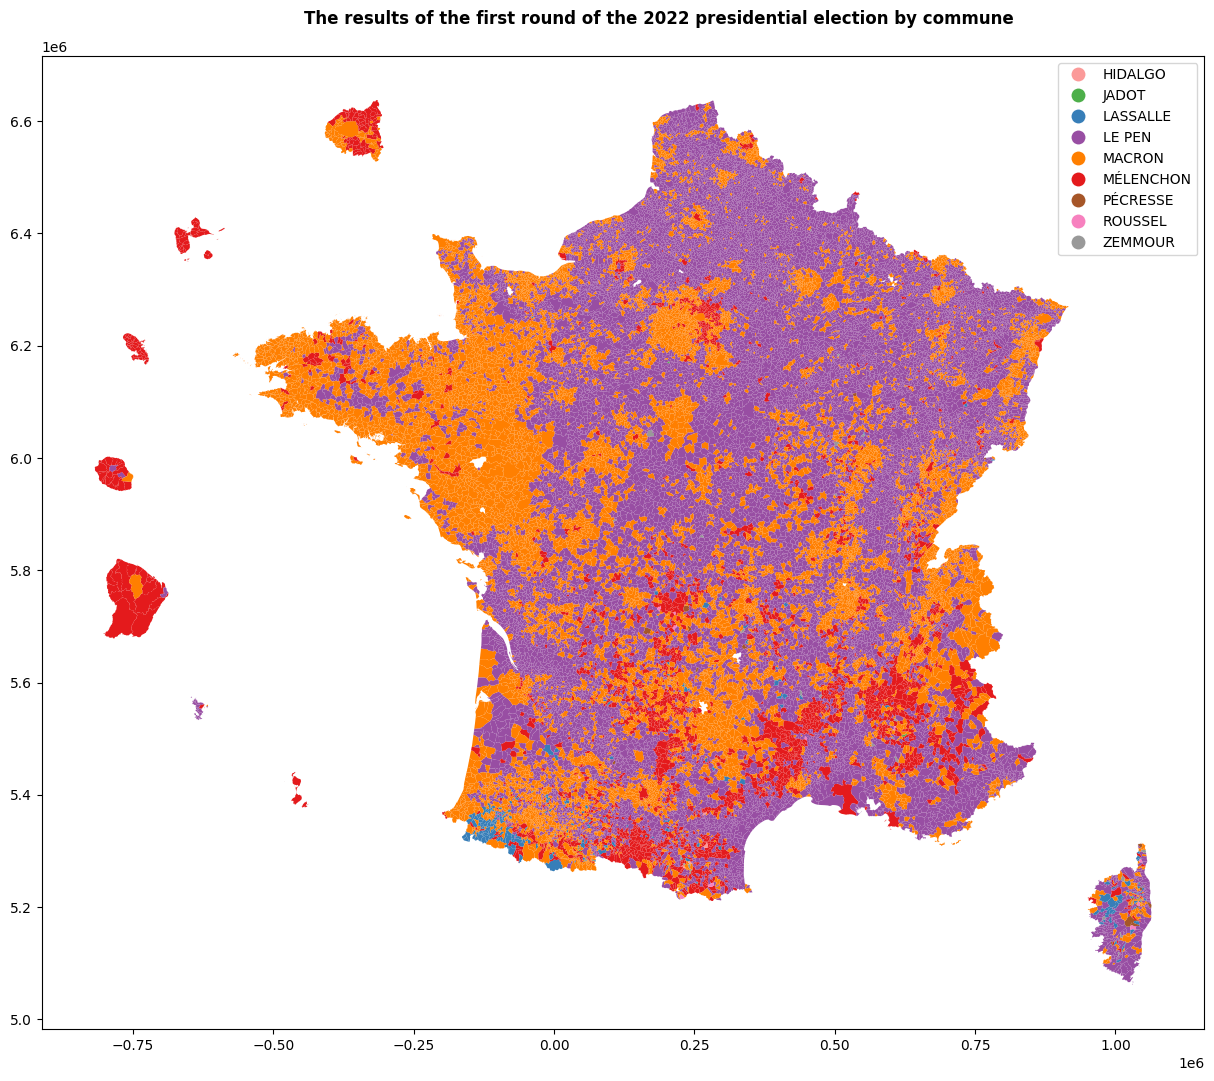

In [11]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
com.plot(column='Nom', legend=True, ax=ax, cmap=cmap)
plt.suptitle('The results of the first round of the 2022 presidential election by commune', x = 0.3, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.show()